# Detecto - bounding box incorrect in augmented photo

This notebook is for demonstrating what looks like a bug in drawing bounding boxes for an augmented photo.

# Background

I'm using [Roboflow](https://roboflow.com) to generate augmented images of my dataset.  I've included one of the generated images as a demo.

The image is of the loading tray of a dishwasher, with the various bowls and plates annotated.  The augmented image has, among other things, been sheared.  The bounding boxes were downloaded in VOC XML format.

# Bug (I think)

When loading the image with Detecto, the bounding boxes do not line up with the sheared image.  This *could* be a bug in Roboflow, or me loading files incorrectly, or something else.  However, when I parse the VOC XML file manually and plot the bounding boxes using [the imgaug library](https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html), they seem to line up just fine.  Thus, I suspect there is a bug in Detecto.

Installing requirements should be done outside of this notebook; run `pip install -r requirements.txt` in the root of this repo.

First, import matplotlib and detecto:

In [1]:
import matplotlib.pyplot as plt
from detecto.visualize import show_labeled_image
from detecto.core import Dataset

/home/aardvark/dev/detecto_bug/.venv/lib64/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


I've put an example image and its VOC file in this directory.  If you need more examples, please let me know.

In [2]:
dataset = Dataset("./dataset/")

Display the image with bounding boxes.  The colours make it a bit hard to see what's going on, but:

- There's a mixing bowl centered around x=200, y=100, but the mixing bowl box apears to be off; the lower right-hand corner of the box and its label are at approximately x=150, y=250.

- There's a plate oriented horizontally at approximately x=200 to 300, y=200; but its bounding box is oriented vertically, with its lower right-hand corner at approximately x=200, y=325.

- There are a couple bowls at approximately x=100, y=150 to 250.  The bounding boxes are a little unclear to me, so I'll leave them out of this discussion.

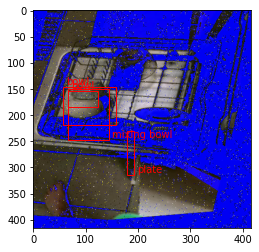

In [3]:
image, targets = dataset[0]
show_labeled_image(image, targets['boxes'], targets['labels'])

In [4]:
targets

{'boxes': tensor([[ 57, 147, 158, 218],
         [ 67, 154, 124, 184],
         [145, 248,  67, 150],
         [193, 314, 178, 230]]),
 'labels': ['bowl', 'bowl', 'mixing bowl', 'plate']}

Import imageio, and create variables for the image file and its annotation file:

In [5]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

bug_img = "./dataset/bug_demo.jpg"
bug_annotation_file = "./dataset/bug_demo.xml"

Display the image on its own, just for context:

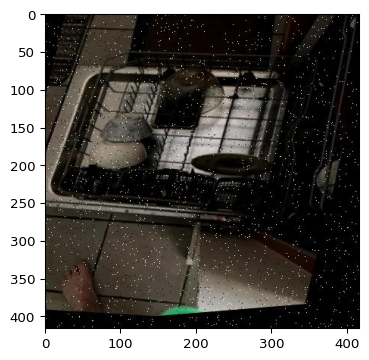

In [6]:
image = imageio.imread(bug_img)
ia.imshow(image)

Load the annotation file and parse it manually:

In [7]:
# https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        xmin, ymin, xmax, ymax = None, None, None, None

        xmin = int(boxes.find("bndbox/xmin").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        name = str(boxes.find("name").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax, name]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

name, boxes = read_content(bug_annotation_file)

Print out `name` and `boxes` to sanity-check:

In [8]:
name, boxes

('bug_demo.jpg',
 [[57, 158, 147, 218, 'bowl'],
  [67, 124, 154, 184, 'bowl'],
  [145, 67, 248, 150, 'mixing bowl'],
  [193, 178, 314, 230, 'plate']])

Finally, use the imgaug library to display the image and the bounding boxes.  Note how the boxes appear to match the items much better:

In [9]:
all_bounding_boxes = []
for box in boxes:
    bbox = BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3])
    bbox.label = box[4]
    all_bounding_boxes.append(bbox)

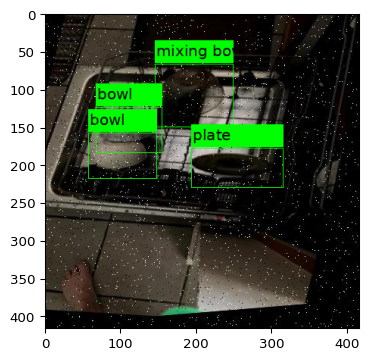

In [10]:
bbs_for_first_img = BoundingBoxesOnImage(all_bounding_boxes, shape=image.shape)
ia.imshow(bbs_for_first_img.draw_on_image(image, size=1))

# Focusing on one example

I'll focus on the case of the very first bounding box in `bug_demo.xml`:

```xml
	<object>
		<name>bowl</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>57</xmin>
			<xmax>147</xmax>
			<ymin>158</ymin>
			<ymax>218</ymax>
		</bndbox>
```

In detecto, this is `targets[0]`:

In [11]:
targets['boxes'][0], targets['labels'][0]

(tensor([ 57, 147, 158, 218]), 'bowl')

The code for `show_labelled_image` has this code:

```python
    # Plot each box
    for i in range(boxes.shape[0]):
        box = boxes[i]
        width, height = (box[2] - box[0]).item(), (box[3] - box[1]).item()
        initial_pos = (box[0].item(), box[1].item())
        rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                 edgecolor='r', facecolor='none')
        if labels:
            ax.text(box[0] + 5, box[1] - 5, '{}'.format(labels[i]), color='red')

        ax.add_patch(rect)
```

The two lines in the middle are the crucial bit.  They appear to assume that:

- box[2] == xmax, and box[0] == xmin
- box[3] == ymax, and box[1] == ymin

However, the `targets` variable shows that these coordinates are stored differently:

- box[2] == ymin (not xmax)
- box[1] == xmax (not ymin)

Another way to say this:  the boxes are _stored_ as:

```
[xmin, xmax, ymin, ymax] # as shown by `targets` variable
```

but are _used_ in `show_labelled_image` as:

```
[xmin, ymin, xmax, ymax]
```



Thanks for looking at this, and please let me know if you need any further info.

# Update: Examining xml_to_csv

First, let's see what `xml_to_csv()` will do with our dataset file:

In [12]:
from detecto.utils import xml_to_csv

df = xml_to_csv('./dataset')
df

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,bug_demo.jpg,416,416,bowl,57,147,158,218,0
1,bug_demo.jpg,416,416,bowl,67,154,124,184,0
2,bug_demo.jpg,416,416,mixing bowl,145,248,67,150,0
3,bug_demo.jpg,416,416,plate,193,314,178,230,0


Hm....something's wrong with that function, though I can't see anything obviously wrong.  Let's try adding its code in here and running it directly.

Note:  This code was copied from the output of `xml_to_csv??`.  I've added the `import glob` at the top, set `xml_folder` directly, and just printed out the data frame at the end.


In [13]:
from glob import glob
import pandas as pd

xml_list = []
xml_folder = './dataset'
output_file = None
image_id = 0
# Loop through every XML file
for xml_file in glob(xml_folder + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Each object represents each actual image label
    for member in root.findall('object'):
        box = member.find('bndbox')
        label = member.find('name').text

        # Add image file name, image size, label, and box coordinates to CSV file
        row = (filename, width, height, label, int(float(box[0].text)),
               int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text)), image_id)
        xml_list.append(row)
    
    image_id += 1

# Save as a CSV file
column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'image_id']
xml_df_old_code = pd.DataFrame(xml_list, columns=column_names)

xml_df_old_code

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,bug_demo.jpg,416,416,bowl,57,147,158,218,0
1,bug_demo.jpg,416,416,bowl,67,154,124,184,0
2,bug_demo.jpg,416,416,mixing bowl,145,248,67,150,0
3,bug_demo.jpg,416,416,plate,193,314,178,230,0


Yep, that's definitely incorrect: the row building in that function grabs values by array index rather than finding them via the XML element.

Looking at [the current master branch](https://github.com/alankbi/detecto/blob/master/detecto/utils.py#L251-L282), though, the code is different.  I'll put that here:

In [14]:
xml_list = []
image_id = 0
# Loop through every XML file
for xml_file in glob(xml_folder + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Each object represents each actual image label
    for member in root.findall('object'):
        box = member.find('bndbox')
        label = member.find('name').text

        # Add image file name, image size, label, and box coordinates to CSV file
        row = (filename, width, height, label, int(float(box.find('xmin').text)),
               int(float(box.find('ymin').text)), int(float(box.find('xmax').text)), int(float(box.find('ymax').text)), image_id)
        xml_list.append(row)
    
    image_id += 1

# Save as a CSV file
column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'image_id']
xml_df_new_code = pd.DataFrame(xml_list, columns=column_names)

xml_df_new_code

,filename,width,height,class,xmin,ymin,xmax,ymax,image_id
0,bug_demo.jpg,416,416,bowl,57,158,147,218,0
1,bug_demo.jpg,416,416,bowl,67,124,154,184,0
2,bug_demo.jpg,416,416,mixing bowl,145,67,248,150,0
3,bug_demo.jpg,416,416,plate,193,178,314,230,0


That's better!  Let's try graphing that:

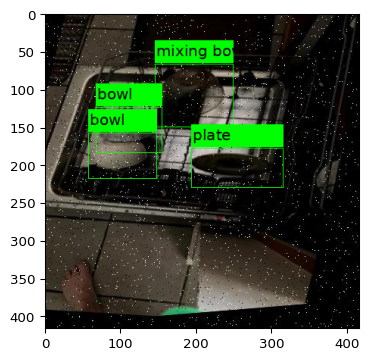

In [15]:
all_bounding_boxes = []
for index, row in xml_df_new_code.iterrows():
    bbox = BoundingBox(x1=row['xmin'], y1=row['ymin'], x2=row['xmax'], y2=row['ymax'])
    bbox.label = row['class']
    all_bounding_boxes.append(bbox)
    
bbs_for_first_img = BoundingBoxesOnImage(all_bounding_boxes, shape=image.shape)
ia.imshow(bbs_for_first_img.draw_on_image(image, size=1))

Looks good.  Just to be sure, let's do the same for `xml_df_old_code`:

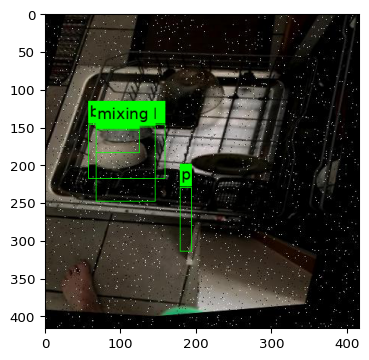

In [16]:
all_bounding_boxes = []
for index, row in xml_df_old_code.iterrows():
    bbox = BoundingBox(x1=row['xmin'], y1=row['ymin'], x2=row['xmax'], y2=row['ymax'])
    bbox.label = row['class']
    all_bounding_boxes.append(bbox)
    
bbs_for_first_img = BoundingBoxesOnImage(all_bounding_boxes, shape=image.shape)
ia.imshow(bbs_for_first_img.draw_on_image(image, size=1))

# Conclusion

I think a new version of detecto needs to be released to include https://github.com/alankbi/detecto/commit/2938bab333997fd0696f5ece1dc504e30b0414eb.